Installation et configuration de Spark

In [3]:

!apt-get install openjdk-11-jdk-headless -qq > /dev/null


!curl -L -o spark.tgz https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar -xzf spark.tgz


!pip install -q findspark


import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  370M  100  370M    0     0  10.7M      0  0:00:34  0:00:34 --:--:-- 5180k


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Fusion de fichiers volumineux") \
    .getOrCreate()


Lecture des fichiers CSV

In [5]:

products_df = spark.read.csv("products.csv", header=True, inferSchema=True)
categories_df = spark.read.csv("categories.csv", header=True, inferSchema=True)


products_df.show(5)
categories_df.show(5)


+----------+---------+-----------+------+
|product_id|     name|category_id| price|
+----------+---------+-----------+------+
|         1|Product 1|         10|453.38|
|         2|Product 2|         17|424.83|
|         3|Product 3|         14|421.32|
|         4|Product 4|         18|186.62|
|         5|Product 5|          4|197.78|
+----------+---------+-----------+------+
only showing top 5 rows

+-----------+-------------+
|category_id|category_name|
+-----------+-------------+
|          1|   Category 1|
|          2|   Category 2|
|          3|   Category 3|
|          4|   Category 4|
|          5|   Category 5|
+-----------+-------------+
only showing top 5 rows



Jointure entre les 2 fichiers

In [6]:

joined_df = products_df.join(categories_df, on="category_id", how="inner")


joined_df.select("product_id", "name", "price", "category_name").show(10, truncate=False)


+----------+----------+------+-------------+
|product_id|name      |price |category_name|
+----------+----------+------+-------------+
|1         |Product 1 |453.38|Category 10  |
|2         |Product 2 |424.83|Category 17  |
|3         |Product 3 |421.32|Category 14  |
|4         |Product 4 |186.62|Category 18  |
|5         |Product 5 |197.78|Category 4   |
|6         |Product 6 |65.68 |Category 13  |
|7         |Product 7 |261.06|Category 12  |
|8         |Product 8 |410.39|Category 8   |
|9         |Product 9 |414.86|Category 3   |
|10        |Product 10|225.5 |Category 5   |
+----------+----------+------+-------------+
only showing top 10 rows



Analyses

In [7]:

joined_df.groupBy("category_name").count().orderBy("count", ascending=False).show()


joined_df.groupBy("category_name").avg("price").orderBy("avg(price)", ascending=False).show()


+-------------+-----+
|category_name|count|
+-------------+-----+
|  Category 16|  554|
|   Category 5|  547|
|  Category 12|  521|
|   Category 2|  518|
|   Category 9|  515|
|  Category 17|  513|
|   Category 1|  510|
|  Category 20|  509|
|  Category 14|  506|
|   Category 6|  503|
|  Category 15|  500|
|   Category 3|  491|
|  Category 10|  489|
|   Category 4|  486|
|  Category 18|  485|
|   Category 8|  482|
|  Category 13|  476|
|  Category 11|  472|
|   Category 7|  462|
|  Category 19|  461|
+-------------+-----+

+-------------+------------------+
|category_name|        avg(price)|
+-------------+------------------+
|  Category 12| 263.8353166986564|
|  Category 16| 259.5349097472927|
|   Category 7|259.36474025974024|
|   Category 2| 257.9075868725869|
|  Category 19| 253.8365292841647|
|   Category 1| 252.9346078431371|
|   Category 8|252.36506224066397|
|  Category 17|251.83421052631556|
|   Category 4|250.60310699588476|
|   Category 5|  250.163034734918|
|  Category 10| 

Analyses et visualisation avec matplolib

In [8]:
import matplotlib.pyplot as plt


joined_pd = joined_df.select("category_name", "price").toPandas()


Produits par catégories

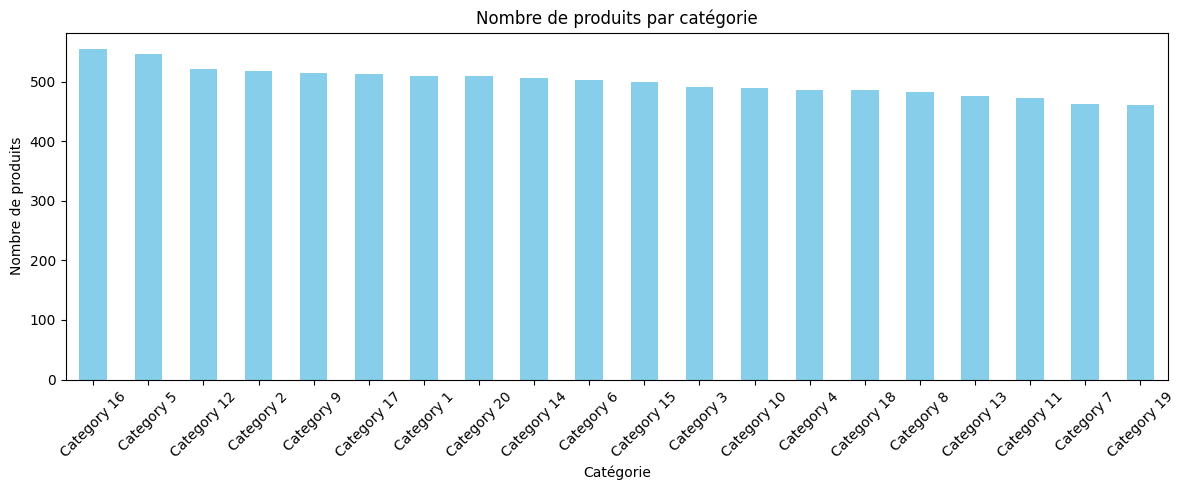

In [9]:
prod_par_cat = joined_pd['category_name'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12,5))
prod_par_cat.plot(kind='bar', color='skyblue')
plt.title("Nombre de produits par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Nombre de produits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Prix moyen par catégorie

In [10]:
prix_moyen = joined_pd.groupby("category_name")["price"].mean().sort_values(ascending=False)

plt.figure(figsize=(12,5))
prix_moyen.plot(kind='bar', color='orange')
plt.title("Prix moyen par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Prix moyen (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Distribution des prix (histogramme)

In [11]:
plt.figure(figsize=(10,5))
plt.hist(joined_pd["price"], bins=50, color='green', edgecolor='black')
plt.title("Distribution des prix")
plt.xlabel("Prix (€)")
plt.ylabel("Nombre de produits")
plt.tight_layout()
plt.show()
